In [37]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
jokes_all = pd.read_csv('../data/jokes.csv')
jokes_all['dad'] = jokes_all['subreddit'].map(lambda x: 1 if x == 'dadjokes' else 0)

In [3]:
p_stemmer = PorterStemmer()
def porter(text):
    text_l = text.split()
    for i in range(len(text_l)):
        text_l[i] = p_stemmer.stem(text_l[i])
    return ' '.join(text_l)

jokes_all['porter'] = jokes_all['full_text'].map(porter)
jokes_all[['full_text','porter']].head()

,full_text,porter
0,Anybody know that show Naked and Afraid? That'...,anybodi know that show nake and afraid? that' ...
1,You don't need a therapist.... A 5 year old wi...,you don't need a therapist.... a 5 year old wi...
2,Why are fizzy drinks so tasty? They are soda-l...,whi are fizzi drink so tasty? they are soda-lici
3,I tried drag racing the other day It's brutal ...,i tri drag race the other day it' brutal run i...
4,"In the next season of Ozark, Marty becomes the...","in the next season of ozark, marti becom the m..."


In [39]:
jokes_all['ft_length'] = jokes_all['full_text'].map(lambda x: len(x))
jokes_all['ft_wc'] = jokes_all['full_text'].map(lambda x: len(x.split()))

sent = SentimentIntensityAnalyzer()
jokes_all['sent_compound'] = [sent.polarity_scores(x)['compound'] for x in jokes_all['full_text']]
jokes_all['sent_neg'] = [sent.polarity_scores(x)['neg'] for x in jokes_all['full_text']]
jokes_all['sent_neu'] = [sent.polarity_scores(x)['neu'] for x in jokes_all['full_text']]
jokes_all['sent_pos'] = [sent.polarity_scores(x)['pos'] for x in jokes_all['full_text']]
jokes_all.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,full_text,dad,porter,ft_length,ft_wc,sent_compound,sent_neg,sent_neu,sent_pos
0,0,Anybody know that show Naked and Afraid?,That's what I call hide and seek with my uncle...,dadjokes,1627664369,Moose908H,3,1,True,Anybody know that show Naked and Afraid? That'...,1,anybodi know that show nake and afraid? that' ...,91,18,-0.1779,0.096,0.904,0.0
1,1,You don't need a therapist....,A 5 year old will tell you everything that's w...,dadjokes,1627664264,VERBERD,2,1,True,You don't need a therapist.... A 5 year old wi...,1,you don't need a therapist.... a 5 year old wi...,104,19,-0.4767,0.171,0.829,0.0
2,2,Why are fizzy drinks so tasty?,They are soda-licious,dadjokes,1627664007,techtornado,3,1,True,Why are fizzy drinks so tasty? They are soda-l...,1,whi are fizzi drink so tasty? they are soda-lici,52,9,0.0000,0.000,1.000,0.0
3,3,I tried drag racing the other day,It's brutal running in those heels!,dadjokes,1627662305,Moose908H,1,1,True,I tried drag racing the other day It's brutal ...,1,i tri drag race the other day it' brutal run i...,69,13,-0.7424,0.386,0.614,0.0
4,4,"In the next season of Ozark, Marty becomes the...",Byrde is the Word,dadjokes,1627661919,DinglebarryHandpump,0,1,True,"In the next season of Ozark, Marty becomes the...",1,"in the next season of ozark, marti becom the m...",72,14,0.0000,0.000,1.000,0.0


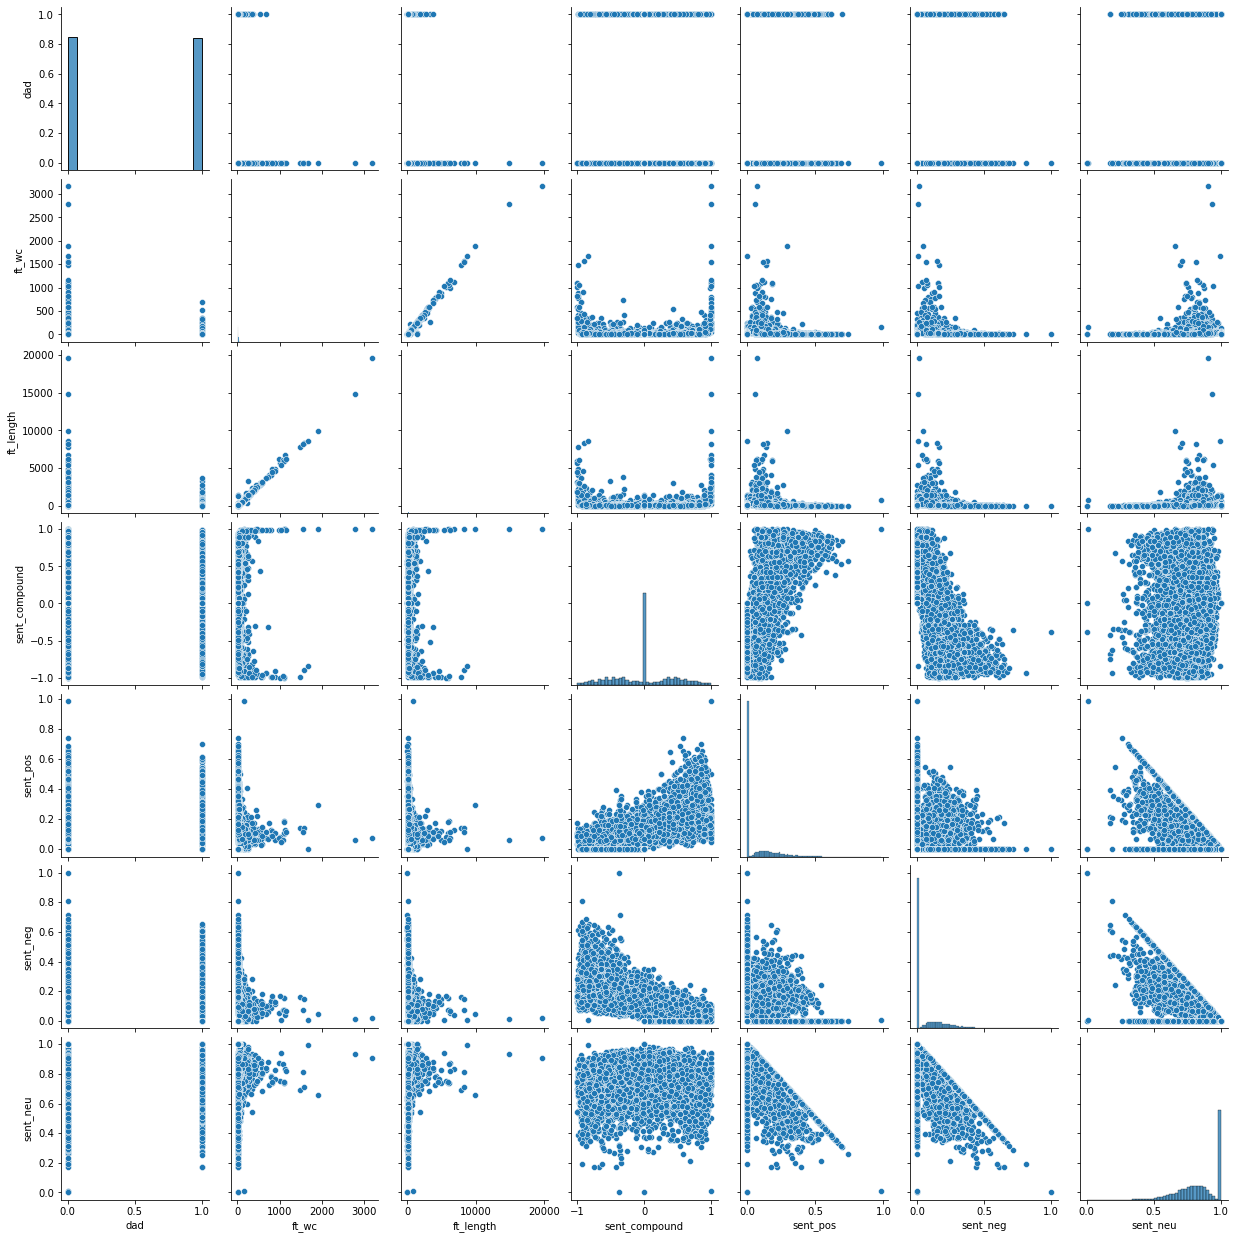

In [40]:
sns.pairplot(jokes_all[['dad','ft_wc','ft_length',
                                'sent_compound','sent_pos',
                                'sent_neg','sent_neu']])


In [41]:
stop_dad = ['dad','son','daughter','son','anti','antijokes','antijoke']

In [42]:
Xport = jokes_all[['porter','ft_wc','ft_length','sent_compound','sent_pos','sent_neg','sent_neu']]
yport = jokes_all['dad']

Xport_train, Xport_test, yport_train, yport_test = train_test_split(Xport,yport,test_size=0.2,random_state=42)

In [49]:
cv_port = TfidfVectorizer(min_df=4,ngram_range=(1,6),stop_words=stop_dad)
Xport_train_cv = cv_port.fit_transform(Xport_train['porter'])

Xport_train_df = pd.DataFrame(Xport_train_cv.todense(),
                              columns=cv_port.get_feature_names()).reset_index()

Xport_train_sent = Xport_train[['ft_wc','ft_length',
                                'sent_compound','sent_pos',
                                'sent_neg','sent_neu']].reset_index()

Xport_train_df = pd.concat([Xport_train_df,Xport_train_sent],axis = 1)

In [50]:
Xport_test_cv = cv_port.transform(Xport_test['porter'])
Xport_test_df = pd.DataFrame(Xport_test_cv.todense(),
                             columns=cv_port.get_feature_names()).reset_index()

Xport_test_sent = Xport_test[['ft_wc','ft_length',
                              'sent_compound','sent_pos',
                              'sent_neg','sent_neu']].reset_index()

Xport_test_df = pd.concat([Xport_test_df,Xport_test_sent],axis = 1)
print(Xport_train_df.shape,Xport_test_df.shape)

(9669, 15203) (2418, 15203)


In [51]:
ss = StandardScaler(with_mean=False)

Ztrain = ss.fit_transform(Xport_train_df,yport_train)
Ztest = ss.transform(Xport_test_df)
print(Ztrain.shape,Ztest.shape)
lr = LogisticRegressionCV(random_state=42,penalty = 'l1',max_iter = 100000,
                              solver = 'liblinear',Cs=np.logspace(0,2,21), cv = 5,verbose = 10)
lr.fit(Ztrain,yport_train)

(9669, 15203) (2418, 15203)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.6s remaining:    0.0s


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.2s remaining:    0.0s


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.9s finished


[LibLinear]

LogisticRegressionCV(Cs=array([  1.        ,   1.25892541,   1.58489319,   1.99526231,
         2.51188643,   3.16227766,   3.98107171,   5.01187234,
         6.30957344,   7.94328235,  10.        ,  12.58925412,
        15.84893192,  19.95262315,  25.11886432,  31.6227766 ,
        39.81071706,  50.11872336,  63.09573445,  79.43282347,
       100.        ]),
                     cv=5, max_iter=100000, penalty='l1', random_state=42,
                     solver='liblinear', verbose=10)

In [52]:
lr.score(Ztrain, yport_train), lr.score(Ztest, yport_test),lr.C_

(1.0, 0.9755996691480563, array([1.]))

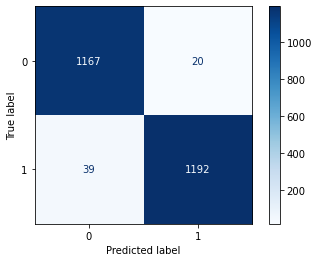

In [53]:
preds = lr.predict(Ztest)

tn, fp, fn, tp = confusion_matrix(yport_test, preds).ravel()
plot_confusion_matrix(lr, Ztest, yport_test, cmap='Blues');


In [54]:
fit_list = []
for i,j in zip(cv_port.get_feature_names(),lr.coef_[0]):
    if j != 0:
        fit_list.append([i,j])
sorted_fit = sorted(fit_list, key=lambda x:abs(x[1]))        
len(sorted_fit),sorted_fit[::-1]


(1695,
 [['my 10', 0.3667839251320598],
  ['and 10', -0.34410676690292674],
  ['wa abl', 0.2805316592917987],
  ['it about', 0.2505248477981213],
  ['where are', 0.22597558172366644],
  ['you could say', 0.21734129839706956],
  ['hear about the guy', 0.20310320052105862],
  ['what do an', 0.1907611754039437],
  ['not actual', -0.17096452873237844],
  ['00', 0.16794508098582606],
  ['catch him', 0.1492134150996581],
  ['bananas', -0.1484334650218838],
  ['by the', 0.14147204659212895],
  ['make an', 0.138902255980224],
  ['your age', -0.13853374214684644],
  ['now and', 0.13768623135956706],
  ['the chicken cross the road', -0.13627601775736767],
  ['black and', -0.1349348211910632],
  ['light bulb', 0.13136007479229442],
  ['crash', 0.13053332849854724],
  ['probabl be', -0.1257108620114479],
  ['of alcohol', 0.12456026123268935],
  ['they actual', 0.12277669142675907],
  ['me about', 0.12068876829732043],
  ['truck', 0.11489993354059244],
  ['job at', 0.11449701819201064],
  ['you mak

In [48]:
fit_list = []
for i,j in zip(cv_port.get_feature_names(),lr.coef_[0]):
    if j != 0:
        fit_list.append([i,j])
sorted_fit = sorted(fit_list, key=lambda x:abs(x[1]))        
len(sorted_fit),sorted_fit[::-1]


(1695,
 [['my 10', 0.3667839251320598],
  ['and 10', -0.34410676690292674],
  ['wa abl', 0.2805316592917987],
  ['it about', 0.2505248477981213],
  ['where are', 0.22597558172366644],
  ['you could say', 0.21734129839706956],
  ['hear about the guy', 0.20310320052105862],
  ['what do an', 0.1907611754039437],
  ['not actual', -0.17096452873237844],
  ['00', 0.16794508098582606],
  ['catch him', 0.1492134150996581],
  ['bananas', -0.1484334650218838],
  ['by the', 0.14147204659212895],
  ['make an', 0.138902255980224],
  ['your age', -0.13853374214684644],
  ['now and', 0.13768623135956706],
  ['the chicken cross the road', -0.13627601775736767],
  ['black and', -0.1349348211910632],
  ['light bulb', 0.13136007479229442],
  ['crash', 0.13053332849854724],
  ['probabl be', -0.1257108620114479],
  ['of alcohol', 0.12456026123268935],
  ['they actual', 0.12277669142675907],
  ['me about', 0.12068876829732043],
  ['truck', 0.11489993354059244],
  ['job at', 0.11449701819201064],
  ['you mak